In [1]:
import bauwerk
import gym
import numpy as np

EVAL_LEN = 24*30 # evaluate on 1 month of actions

# Create SolarBatteryHouse environment
env = gym.make("bauwerk/SolarBatteryHouse-v0")

# the function below basically calculates a reward for each action, and then adds that reward to the cumulative reward
# this would evaluate the accuracy and significance of the action
def evaluate_actions(actions, env):
    cum_reward = 0
    obs = env.reset()
    for action in actions:
        # if a step is run, obs gets the dictionary of load, pv_gen, battery_cont, time of day
        # reward is a value, terminated and truncated are next values, and info is the last thingies
        obs, reward, terminated, truncated, info = env.step(np.array(action, dtype=np.float32))     ###### HERE I CHANGED STUFF
        cum_reward += reward

    return cum_reward / len(actions)

<__array_function__ internals>:200: RuntimeWarning: overflow encountered in cast


In [2]:
env.cfg

EnvConfig(time_step_len=1.0, episode_len=8759, grid_charging=True, infeasible_control_penalty=False, obs_keys=['load', 'pv_gen', 'battery_cont', 'time_of_day'], action_space_type='relative', dtype='float32', battery_size=7.5, battery_chemistry='NMC', battery_start_charge=0.0, data_start_index=0, solar_data=None, solar_scaling_factor=3.5, solar_noise_magnitude=0.0, load_data=None, load_scaling_factor=4.5, load_noise_magnitude=0.0, grid_peak_threshold=2.0, grid_base_price=0.25, grid_peak_price=1.25, grid_sell_price=0.05, grid_selling_allowed=True, solar=None, battery=None, load=None, grid=None)

In [3]:
# random actions for 100 trials 

env.reset()
random_trials = [evaluate_actions([env.action_space.sample() for _ in range(EVAL_LEN)], env) for _ in range(100)]
p_rand = np.mean(random_trials)
print(f"Avg reward with random actions: {p_rand:.4f}")

# no battery - zeros inputted

env.reset()
nocharge_trials = [evaluate_actions(np.zeros((EVAL_LEN,1)), env) for _ in range(100)]
p_nocharge = np.mean(nocharge_trials)
print(f"Avg reward (per step) with no actions (no charging): {p_nocharge:.4f}")

C:\Users\zhist\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Avg reward with random actions: -0.9663
Avg reward (per step) with no actions (no charging): -0.2528


In [4]:
# here's how to get the necessary info

action = np.float32([0.])
obs, _, _, _, info = env.step(action)

loadInfo = info.get('load')
print(loadInfo[0])

pvProdInfo = info.get('pv_gen')
print(pvProdInfo[0])

batteryInfo = info.get('battery_cont')
print(batteryInfo[0])

0.203805
0.0
0.0


In [6]:
env.reset()
print(env.action_space)

Box(-1.0, 1.0, (1,), float32)


In [8]:
# if the load is higher than pv_gen and battery_cont, we will have to just put 0, so as to not charge the battery 
# and the system will automatically buy from the grid

action_test = np.float32([0])

env.step(action_test)

({'load': array([0.29], dtype=float32),
  'pv_gen': array([0.], dtype=float32),
  'battery_cont': array([0.], dtype=float32),
  'time_of_day': array([0.866, 0.5  ], dtype=float32)},
 -0.0,
 False,
 False,
 {'load': array([0.29], dtype=float32),
  'pv_gen': array([0.], dtype=float32),
  'battery_cont': array([0.], dtype=float32),
  'cost': array([0.], dtype=float32),
  'time_step': 2,
  'time_step_cont': array([2.], dtype=float32),
  'charging_power': 0,
  'power_diff': 0.0,
  'net_load': array([0.], dtype=float32),
  'cum_load': array([0.29], dtype=float32),
  'cum_pv_gen': array([0.], dtype=float32),
  'load_change': array([[-0.29]], dtype=float32),
  'pv_change': array([[0.]], dtype=float32),
  'time_of_day': array([0.866, 0.5  ], dtype=float32)})

In [11]:
# there has to be a calculation made to store battery content - in previous cell, we see that the generation is 0.328, and 
# if we roughtly subtract 0.153, we are left with around 0.15
# the max battery capacity is 7.5, and 0.15 is 0.02 of 7.5, so we can only charge the battery 0.04 or else the 
# environment will buy from the grid to charge the battery
# as you can see, cost went down and reward went up

action_test = np.float32([0.02])

env.step(action_test)

({'load': array([0.], dtype=float32),
  'pv_gen': array([0.452], dtype=float32),
  'battery_cont': array([0.149], dtype=float32),
  'time_of_day': array([0.259, 0.966], dtype=float32)},
 0.0012305021518841386,
 False,
 False,
 {'load': array([0.], dtype=float32),
  'pv_gen': array([0.452], dtype=float32),
  'battery_cont': array([0.149], dtype=float32),
  'cost': array([-0.001], dtype=float32),
  'time_step': 5,
  'time_step_cont': array([5.], dtype=float32),
  'charging_power': 0.14999999664723873,
  'power_diff': 0.0,
  'net_load': array([-0.025], dtype=float32),
  'cum_load': array([0.457], dtype=float32),
  'cum_pv_gen': array([0.779], dtype=float32),
  'load_change': array([[0.153]], dtype=float32),
  'pv_change': array([[-0.124]], dtype=float32),
  'time_of_day': array([0.259, 0.966], dtype=float32)})

In [15]:
# however, it seems that discharging the battery (putting in a negative amt) will only produce money (further lower cost), 
# and can't contribute towards fulfilling the load
# but i suppose that by producing money, the battery technically fills the load since money is needed to buy from the grid

action_test = np.float32([-0.03])

env.step(action_test)

({'load': array([0.], dtype=float32),
  'pv_gen': array([1.954], dtype=float32),
  'battery_cont': array([1.987], dtype=float32),
  'time_of_day': array([-0.707,  0.707], dtype=float32)},
 0.10390999168157578,
 False,
 False,
 {'load': array([0.], dtype=float32),
  'pv_gen': array([1.954], dtype=float32),
  'battery_cont': array([1.987], dtype=float32),
  'cost': array([-0.104], dtype=float32),
  'time_step': 9,
  'time_step_cont': array([9.], dtype=float32),
  'charging_power': -0.2249999949708581,
  'power_diff': 0.0,
  'net_load': array([-2.078], dtype=float32),
  'cum_load': array([0.802], dtype=float32),
  'cum_pv_gen': array([6.754], dtype=float32),
  'load_change': array([[0.244]], dtype=float32),
  'pv_change': array([[0.143]], dtype=float32),
  'time_of_day': array([-0.707,  0.707], dtype=float32)})

In [5]:
# set it and forget it
def SIFI(env):
    actions = []
    
    # env.step returns an initial observation, and some information - like load, photovoltaic generation, battery content
    action1 = np.float32([0.])
    obs, _, _, _, info = env.step(action1)

    loadInfo = info.get('load')
    load = loadInfo[0]
    pvProdInfo = info.get('pv_gen')
    pvgen = pvProdInfo[0]
    batteryInfo = info.get('battery_cont')
    batt = batteryInfo[0]
    for i in range(EVAL_LEN):
        # if solar generation is greater than load, get the remaining solar energy and add it to the battery
        if(pvgen > load):
            diff = pvgen - load
            action2 = diff/7.5
            action = np.float32([action2])
            actions.append(action)
            obs, _, _, _, info = env.step(action)
            loadInfo = info.get('load')
            load = loadInfo[0]
            pvProdInfo = info.get('pv_gen')
            pvgen = pvProdInfo[0]
            batteryInfo = info.get('battery_cont')
            batt = batteryInfo[0]
        # if battery has energy, sell it to get profit
        elif(batt > load):
            action2 = -1
            action = np.float32([action2])
            actions.append(action)
            obs, _, _, _, info = env.step(action)
            loadInfo = info.get('load')
            load = loadInfo[0]
            pvProdInfo = info.get('pv_gen')
            pvgen = pvProdInfo[0]
            batteryInfo = info.get('battery_cont')
            batt = batteryInfo[0]     
        # if battery and solar aren't enough, buy from grid
        else:
            action2 = 0
            action = np.float32([action2])
            obs, _, _, _, info = env.step(action)
            loadInfo = info.get('load')
            load = loadInfo[0]
            pvProdInfo = info.get('pv_gen')
            pvgen = pvProdInfo[0]
            batteryInfo = info.get('battery_cont')
            batt = batteryInfo[0]                

    # this evaluates the actions that have been saved into model_actions
    p_sifi = evaluate_actions(actions[:EVAL_LEN], env)
    return p_sifi

In [6]:
# set it and forget it, 100 trials

env.reset()
SIFI_trials = [SIFI(env) for _ in range(100)]
p_SIFI = np.mean(SIFI_trials)
print(f"Avg reward (per step): {p_SIFI:.4f}")

Avg reward (per step) with no actions (no charging): -0.4697


In [7]:
from stable_baselines3.common.callbacks import BaseCallback

def eval_model(model, env):
    # Obtaining model actions and evaluating them
    model_actions = []
    
    # env.reset returns an initial observation and some information (which we don't use)
    obs, _ = env.reset()     ###### HERE I CHANGED STUFF        ###### HERE I CHANGED STUFF
    for i in range(EVAL_LEN):
        # model.predict gets the policy action from an observation and returns the model's action
            # is policy action and model's action the same?
        # https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html#stable_baselines3.ppo.PPO.predict
        action, _states = model.predict(obs)
        model_actions.append(action)
        obs, _, _, _, _ = env.step(action)                      ###### HERE I CHANGED STUFF

    # this just evaluates the actions that have been saved into model_actions
    p_model = evaluate_actions(model_actions[:EVAL_LEN], env)
    return p_model

class EvalCallback(BaseCallback):
    def __init__(self, eval_freq = 24*7, verbose=0):
        super().__init__(verbose)
        self.data = []
        self.eval_freq = eval_freq
        self.eval_env = gym.make("bauwerk/SolarBatteryHouse-v0")

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.data.append(eval_model(self.model, self.eval_env))

    def _on_step(self) -> bool:
        if self.num_timesteps % self.eval_freq == 0:
            self.data.append(eval_model(self.model, self.eval_env))

        return True

In [8]:
# algorithm 1

from stable_baselines3 import PPO

# NUM_TRAIN_STEP is making steps for 2 years
NUM_TRAIN_STEP = 24 * 365 * 2
env_b = gym.make("bauwerk/SolarBatteryHouse-v0")

model_ppo = PPO(
    policy="MultiInputPolicy",  
    env=env_b,                                 
    verbose=0,
)

ppo_callback = EvalCallback()

# takes in the timesteps, trains on those timesteps, and the callback and returns a trained model
model_ppo.learn(total_timesteps=NUM_TRAIN_STEP,callback=ppo_callback)

# model evaluated
p_model_ppo = eval_model(model_ppo, env)
print(f"Avg reward (per step) with model actions: {p_model_ppo:.4f}")

<__array_function__ internals>:200: RuntimeWarning: overflow encountered in cast
C:\Users\zhist\anaconda3\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
C:\Users\zhist\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Avg reward (per step) with model actions: -0.3224


Text(0.5, 0, 'timesteps (each 1.0h)')

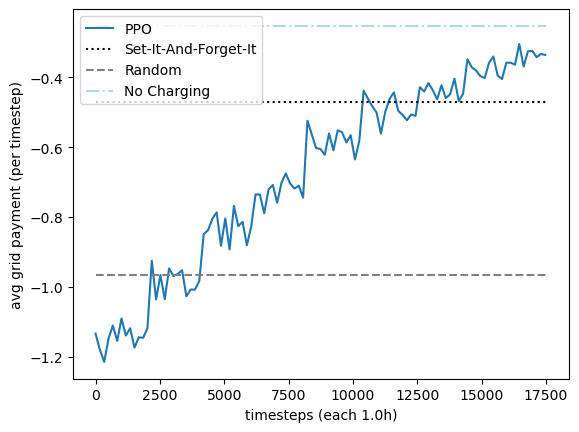

In [9]:
import matplotlib.pyplot as plt

fig=plt.figure()
x = np.arange(0,NUM_TRAIN_STEP,ppo_callback.eval_freq)
plt.plot(
    x, ppo_callback.data[:NUM_TRAIN_STEP//ppo_callback.eval_freq + 1], label="PPO"
)

plt.hlines(p_SIFI, 0, NUM_TRAIN_STEP, label="Set-It-And-Forget-It", linestyle=":", color="black")
plt.hlines(p_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(p_nocharge, 0, NUM_TRAIN_STEP, label="No Charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")

In [10]:
# algorithm 2

from stable_baselines3 import A2C

# NUM_TRAIN_STEP is making steps for 2 years
NUM_TRAIN_STEP = 24 * 365 * 2
env_b = gym.make("bauwerk/SolarBatteryHouse-v0")

model_a2c = A2C(
    policy="MultiInputPolicy",  
    env=env_b,                             
    verbose=0,
)

a2c_callback = EvalCallback()

# takes in the timesteps, trains on those timesteps, and the callback and returns a trained model
model_a2c.learn(total_timesteps=NUM_TRAIN_STEP,callback=a2c_callback)

# model evaluated
p_model_a2c = eval_model(model_a2c, env)
print(f"Avg reward (per step) with model actions: {p_model_a2c:.4f}")

Avg reward (per step) with model actions: -0.2528


Text(0.5, 0, 'timesteps (each 1.0h)')

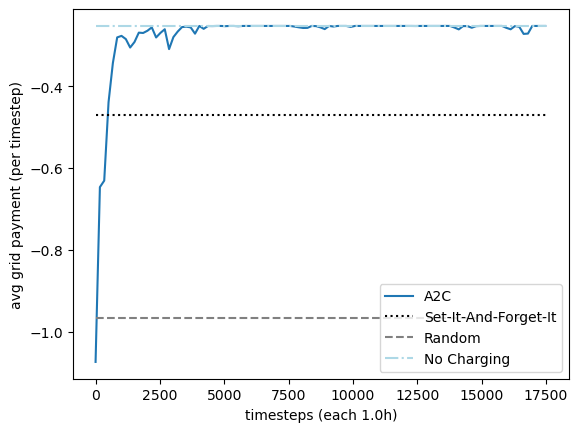

In [11]:
import matplotlib.pyplot as plt

fig=plt.figure()
x = np.arange(0,NUM_TRAIN_STEP,a2c_callback.eval_freq)
plt.plot(
    x, a2c_callback.data[:NUM_TRAIN_STEP//a2c_callback.eval_freq + 1], label="A2C"
)

plt.hlines(p_SIFI, 0, NUM_TRAIN_STEP, label="Set-It-And-Forget-It", linestyle=":", color="black")
plt.hlines(p_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(p_nocharge, 0, NUM_TRAIN_STEP, label="No Charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")

In [12]:
# algorithm 3

from stable_baselines3 import DDPG

# NUM_TRAIN_STEP is making steps for 2 years
NUM_TRAIN_STEP = 24 * 365 * 2
env_b = gym.make("bauwerk/SolarBatteryHouse-v0")

model_ddpg = DDPG(
    policy="MultiInputPolicy",  
    env=env_b,                                           
    verbose=0,
)

ddpg_callback = EvalCallback()

# takes in the timesteps, trains on those timesteps, and the callback and returns a trained model
model_ddpg.learn(total_timesteps=NUM_TRAIN_STEP,callback=ddpg_callback)

# model evaluated
p_model_ddpg = eval_model(model_ddpg, env)
print(f"Avg reward (per step) with model actions: {p_model_ddpg:.4f}")

Avg reward (per step) with model actions: -0.2528


Text(0.5, 0, 'timesteps (each 1.0h)')

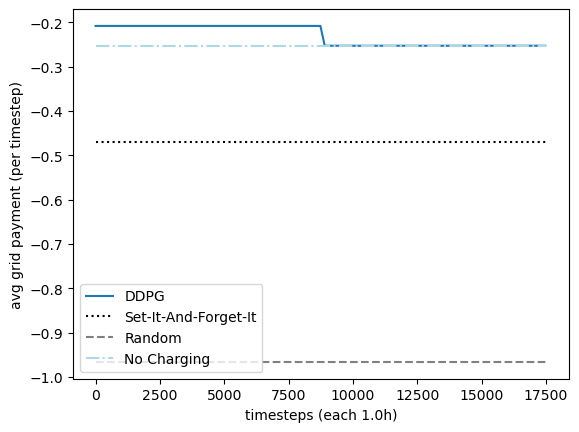

In [13]:
import matplotlib.pyplot as plt

fig=plt.figure()
x = np.arange(0,NUM_TRAIN_STEP,ddpg_callback.eval_freq)
plt.plot(
    x, ddpg_callback.data[:NUM_TRAIN_STEP//ddpg_callback.eval_freq + 1], label="DDPG"
)

plt.hlines(p_SIFI, 0, NUM_TRAIN_STEP, label="Set-It-And-Forget-It", linestyle=":", color="black")
plt.hlines(p_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(p_nocharge, 0, NUM_TRAIN_STEP, label="No Charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")

In [14]:
# algorithm 4

from stable_baselines3 import TD3

# NUM_TRAIN_STEP is making steps for 2 years
NUM_TRAIN_STEP = 24 * 365 * 2
env_b = gym.make("bauwerk/SolarBatteryHouse-v0")

model_td3 = TD3(
    policy="MultiInputPolicy",  
    env=env_b,                                 
    verbose=0,
)

td3_callback = EvalCallback()

# takes in the timesteps, trains on those timesteps, and the callback and returns a trained model
model_td3.learn(total_timesteps=NUM_TRAIN_STEP,callback=td3_callback)

# model evaluated
p_model_td3 = eval_model(model_td3, env)
print(f"Avg reward (per step) with model actions: {p_model_td3:.4f}")

Avg reward (per step) with model actions: -0.1641


Text(0.5, 0, 'timesteps (each 1.0h)')

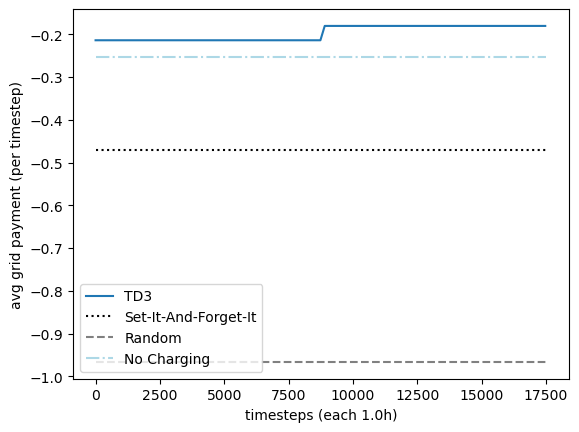

In [15]:
import matplotlib.pyplot as plt

fig=plt.figure()
x = np.arange(0,NUM_TRAIN_STEP,td3_callback.eval_freq)
plt.plot(
    x, td3_callback.data[:NUM_TRAIN_STEP//td3_callback.eval_freq + 1], label="TD3"
)

plt.hlines(p_SIFI, 0, NUM_TRAIN_STEP, label="Set-It-And-Forget-It", linestyle=":", color="black")
plt.hlines(p_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(p_nocharge, 0, NUM_TRAIN_STEP, label="No Charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")

Text(0.5, 0, 'timesteps (each 1.0h)')

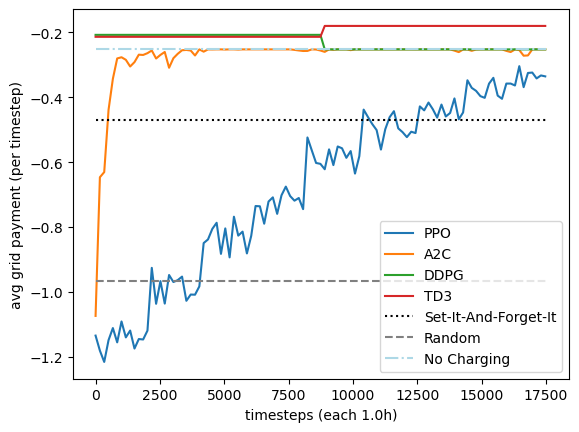

In [16]:
import matplotlib.pyplot as plt

fig=plt.figure()
x = np.arange(0,NUM_TRAIN_STEP,ddpg_callback.eval_freq)
plt.plot(
    x, ppo_callback.data[:NUM_TRAIN_STEP//ppo_callback.eval_freq + 1], label="PPO"
)
plt.plot(
    x, a2c_callback.data[:NUM_TRAIN_STEP//a2c_callback.eval_freq + 1], label="A2C"
)
plt.plot(
    x, ddpg_callback.data[:NUM_TRAIN_STEP//ddpg_callback.eval_freq + 1], label="DDPG"
)
plt.plot(
    x, td3_callback.data[:NUM_TRAIN_STEP//td3_callback.eval_freq + 1], label="TD3"
)

plt.hlines(p_SIFI, 0, NUM_TRAIN_STEP, label="Set-It-And-Forget-It", linestyle=":", color="black")
plt.hlines(p_rand, 0, NUM_TRAIN_STEP, label="Random", linestyle="--", color="grey")
plt.hlines(p_nocharge, 0, NUM_TRAIN_STEP, label="No Charging", linestyle="-.", color="lightblue")
plt.legend()
plt.ylabel(f"avg grid payment (per timestep)")
plt.xlabel(f"timesteps (each {env.cfg.time_step_len}h)")